## Import Needed Libraries

In [1]:
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import  EarlyStopping
print('Loaded Libraries')

Loaded Libraries


In [2]:
train_img_dir = "/kaggle/input/water-segmentation/data/images"
train_mask_dir = "/kaggle/input/water-segmentation/data/labels"

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

def display_image_and_mask(img_path, mask_path):
    img = io.imread(img_path)  # Load TIFF image
    
    # Convert multi-channel image to RGB (Keep first 3 channels)
    if len(img.shape) == 3 and img.shape[-1] > 3:
        img = img[:, :, :3]  # Select the first 3 channels

    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)  # Load mask

    # Convert mask to grayscale if needed
    if mask is not None and len(mask.shape) == 3:
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)

    # Display the image and mask
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img)
    ax[0].set_title("Image")
    ax[0].axis("off")

    ax[1].imshow(mask, cmap="gray")
    ax[1].set_title("Mask")
    ax[1].axis("off")

    plt.show()


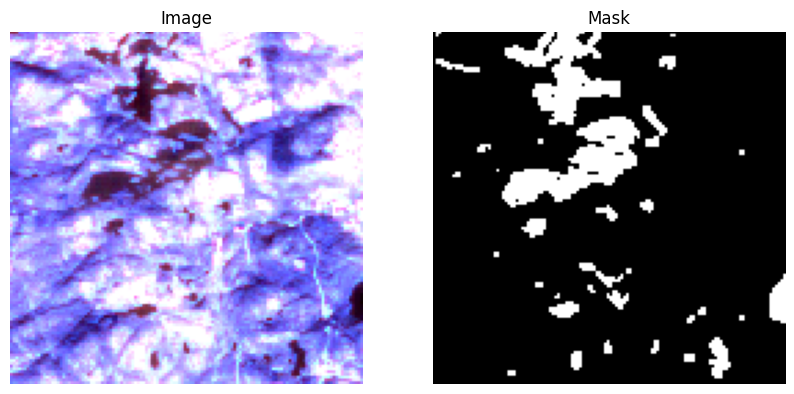

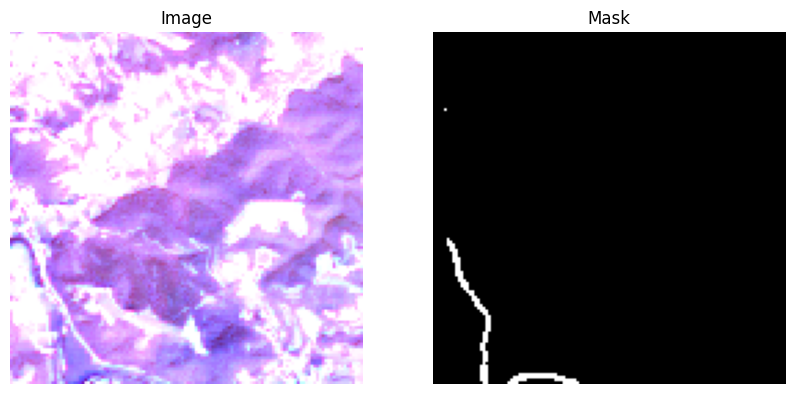

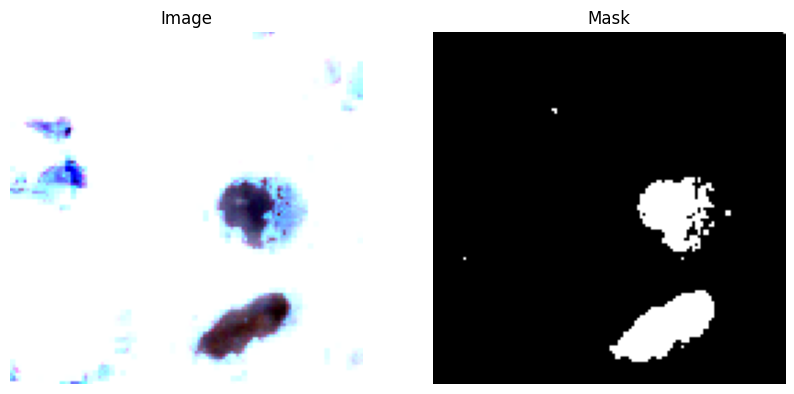

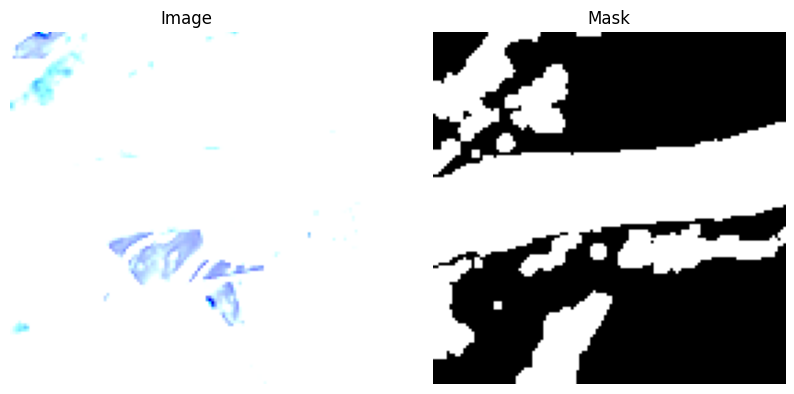

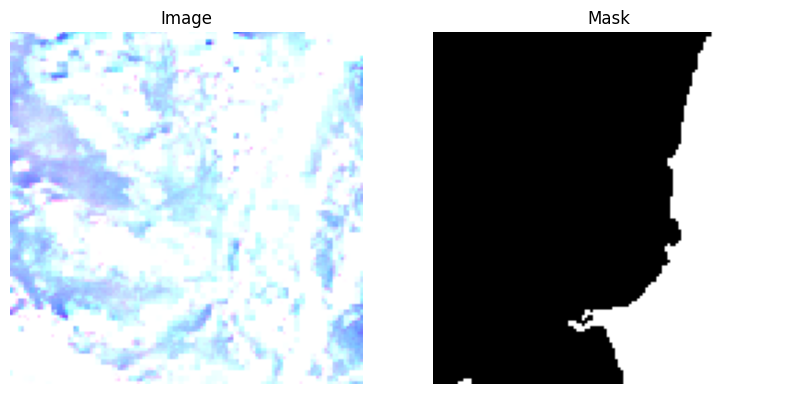

In [4]:
train_img_files = sorted(os.listdir(train_img_dir))
train_mask_files = sorted(os.listdir(train_mask_dir))

for img_file, mask_file in zip(train_img_files[:5], train_mask_files[:5]):
    img_path = os.path.join(train_img_dir, img_file)
    mask_path = os.path.join(train_mask_dir, mask_file)
    display_image_and_mask(img_path, mask_path)

# New

In [5]:
import os
import tifffile as tiff
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# Directories
train_img_dir = "/kaggle/input/water-segmentation/data/images"  # Directory containing .tif images
train_mask_dir = "/kaggle/input/water-segmentation/data/labels"  # Directory containing .png masks

# Collect image and mask file paths
images = [os.path.join(train_img_dir, file) for file in os.listdir(train_img_dir) if file.endswith('.tif')]
masks = [os.path.join(train_mask_dir, file) for file in os.listdir(train_mask_dir) if file.endswith('.png')]

# Check if files exist
if not images or not masks:
    raise ValueError("No .tif images or .png masks found. Check dataset directories.")

# Create dictionaries to match images with masks
image_names = {os.path.splitext(os.path.basename(f))[0]: f for f in images}
mask_names = {os.path.splitext(os.path.basename(f))[0]: f for f in masks}

# Find common keys (matching image-mask pairs)
common_keys = sorted(set(image_names.keys()) & set(mask_names.keys()))

# Ensure only matching images and masks are used
images = [image_names[key] for key in common_keys]
masks = [mask_names[key] for key in common_keys]

# Create DataFrame
data = pd.DataFrame({"image": images, "mask": masks})

# Ensure data is not empty
if data.empty:
    raise ValueError("No matching .tif images and .png masks found. Check filenames.")

# Split data safely
train_df, val_df = train_test_split(data, train_size=0.8, test_size=0.2, shuffle=True, random_state=42)

# Function to load .tif images
def load_image(file_path):
    if file_path.endswith(".tif") or file_path.endswith(".tiff"):
        img = tiff.imread(file_path)  # Load TIFF file
        if len(img.shape) > 2 and img.shape[-1] > 3:  # If more than 3 channels
            img = img[:, :, :3]  # Keep only first 3 channels
        elif len(img.shape) == 2:  # If grayscale, convert to RGB
            img = np.stack([img] * 3, axis=-1)
    else:
        img = cv2.imread(file_path, cv2.IMREAD_COLOR)  # Load as RGB

    img = cv2.resize(img, (128, 128))  # Resize if needed
    return img.astype(np.float32) / 255.0  # Normalize

def load_mask(file_path):
    """Load mask as 1-channel grayscale."""
    mask = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
    mask = cv2.resize(mask, (128, 128))  # Resize if needed
    mask = np.expand_dims(mask, axis=-1)  # Add extra dimension (H, W, 1)
    return mask.astype(np.float32) / 255.0
# Example: Load an image and its mask
sample_image = load_image(train_df.iloc[0]["image"])
sample_mask = load_mask(train_df.iloc[0]["mask"])

print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Image Shape:", sample_image.shape)
print("Mask Shape:", sample_mask.shape)


Train samples: 244
Validation samples: 62
Image Shape: (128, 128, 3)
Mask Shape: (128, 128, 1)


In [6]:
def create_generator(image_paths, mask_paths, batch_size=16):
    while True:
        for i in range(0, len(image_paths), batch_size):
            img_batch = [load_image(img) for img in image_paths[i:i + batch_size]]
            mask_batch = [load_mask(mask) for mask in mask_paths[i:i + batch_size]]

            yield np.array(img_batch), np.array(mask_batch)

train_generator = create_generator(train_df["image"].tolist(), train_df["mask"].tolist())
val_generator = create_generator(val_df["image"].tolist(), val_df["mask"].tolist())
sample_batch = next(train_generator)
print("Train Image Shape:", sample_batch[0].shape)  # (batch_size, 128, 128, 3)
print("Mask Shape:", sample_batch[1].shape)  # (batch_size, 128, 128, 1)

Train Image Shape: (16, 128, 128, 3)
Mask Shape: (16, 128, 128, 1)


In [7]:
def unet_model(input_size=(128, 128, 3)):
    inputs = Input(input_size)

    # Encoder
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)


    # Decoder
    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [8]:
model = unet_model(input_size=(128, 128, 3))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stopping],
    steps_per_epoch=len(train_df) // 16,
    validation_steps=len(val_df) // 16
)

Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.7416 - loss: 0.1817 - val_accuracy: 0.7966 - val_loss: 0.0142
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 430ms/step - accuracy: 0.7319 - loss: 0.0378 - val_accuracy: 0.7876 - val_loss: 0.0189
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.7623 - loss: 0.0197 - val_accuracy: 0.7609 - val_loss: 0.0143
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7407 - loss: 0.0148 - val_accuracy: 0.7566 - val_loss: 0.0127
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7419 - loss: 0.0125 - val_accuracy: 0.7966 - val_loss: 0.0091
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7033 - loss: 0.0127 - val_accuracy: 0.7876 - val_loss: 0.0082
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7431 - loss: 0.0096 - val_accuracy: 0.7609 - val_loss: 0.0080
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - accuracy: 0.7213 - loss: 0.0091 - val_accuracy: 0.75

In [11]:
loss, accuracy = model.evaluate(val_generator, steps=50)
print(f'Validation Loss: {loss}')
print(f'Validation Accuracy: {accuracy}')

50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7808 - loss: 0.0067
Validation Loss: 0.006782486103475094
Validation Accuracy: 0.7776389122009277


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


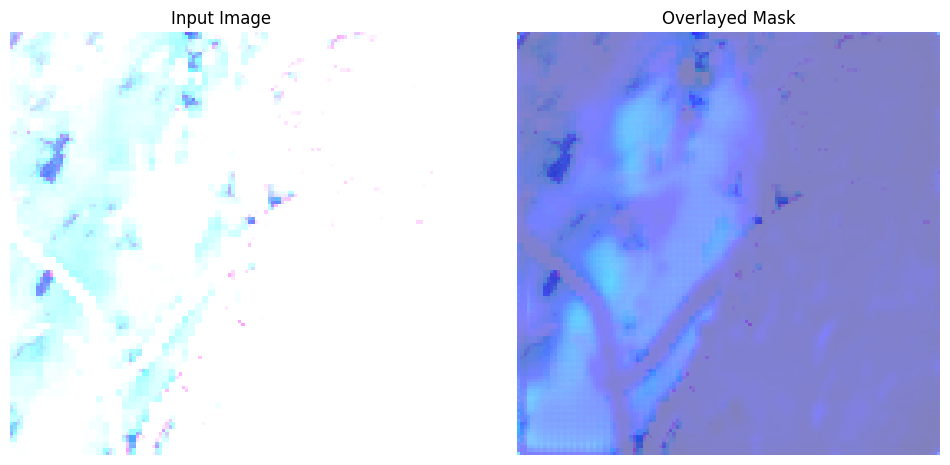

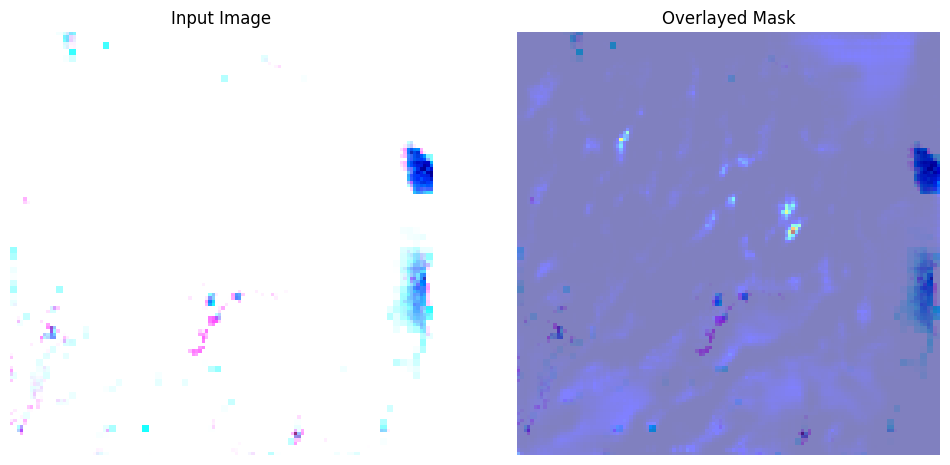

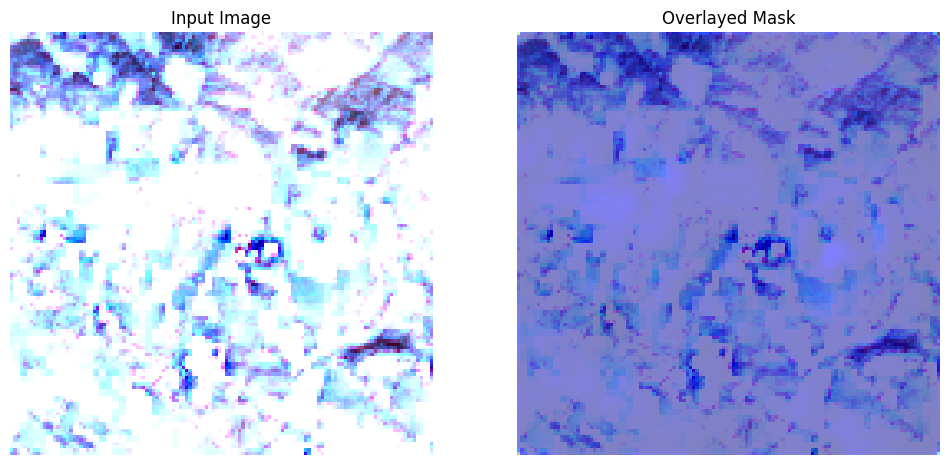

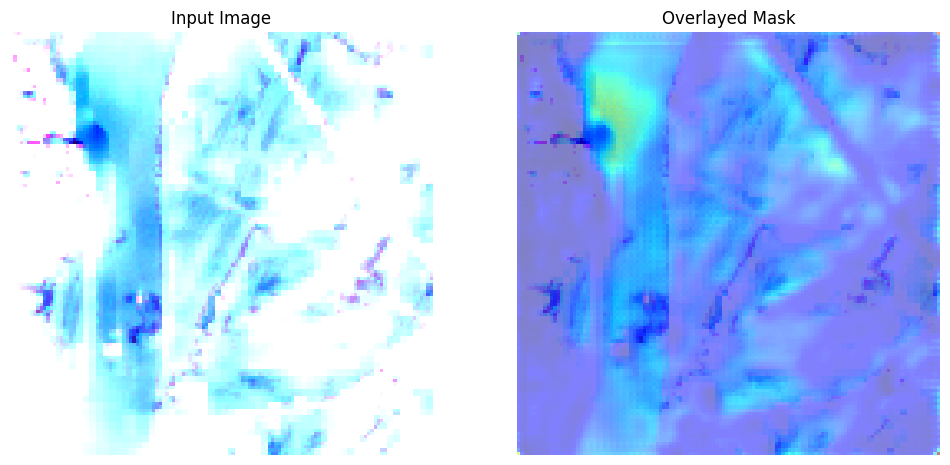

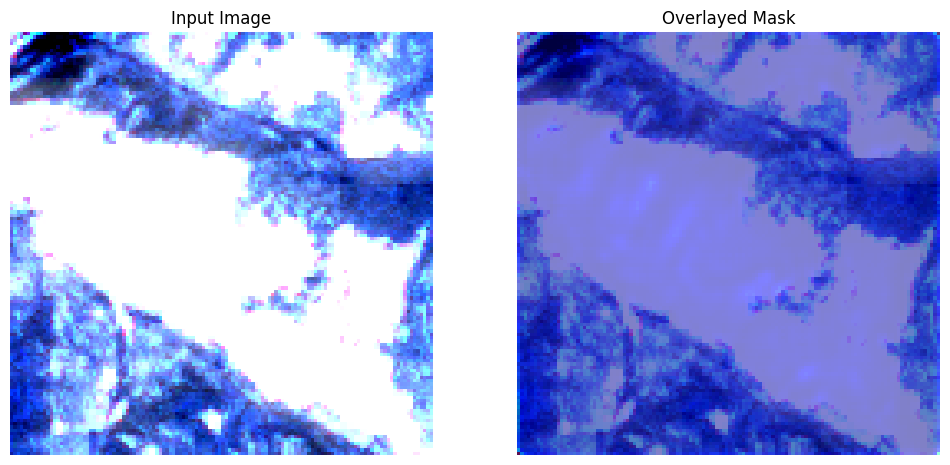

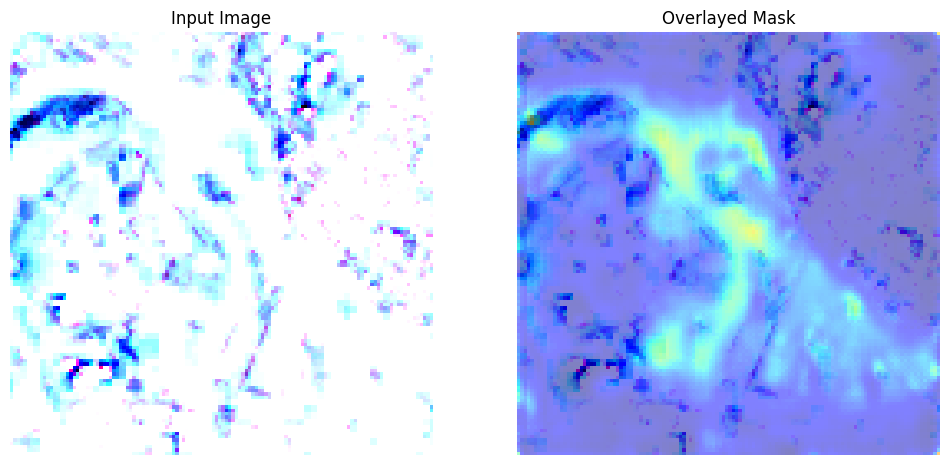

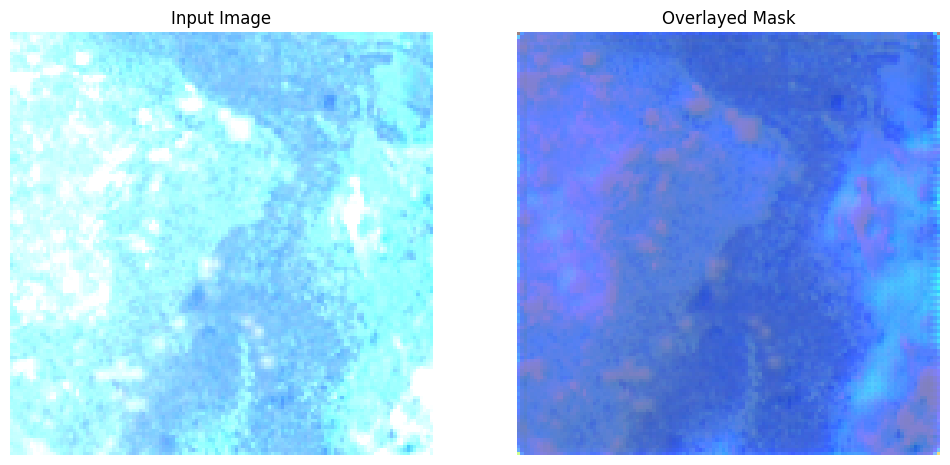

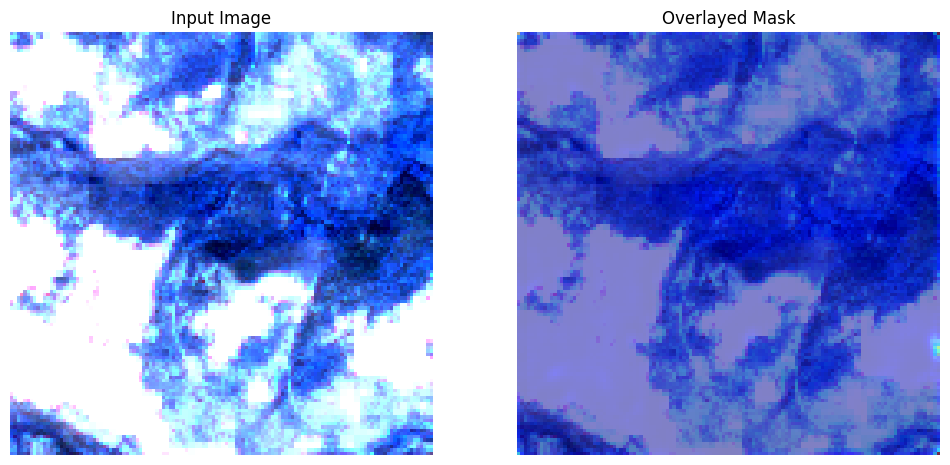

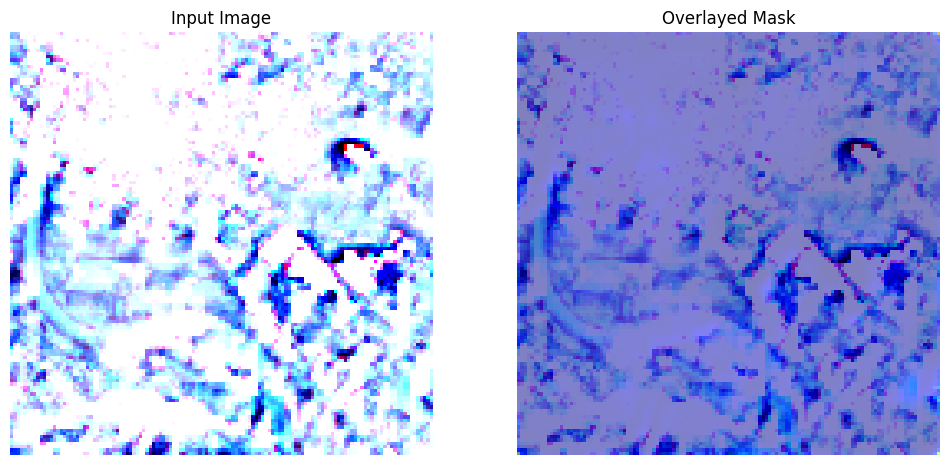

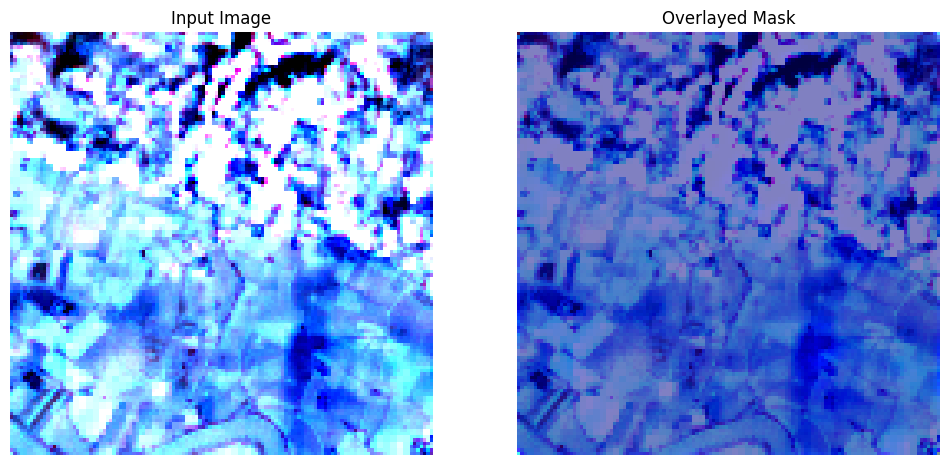

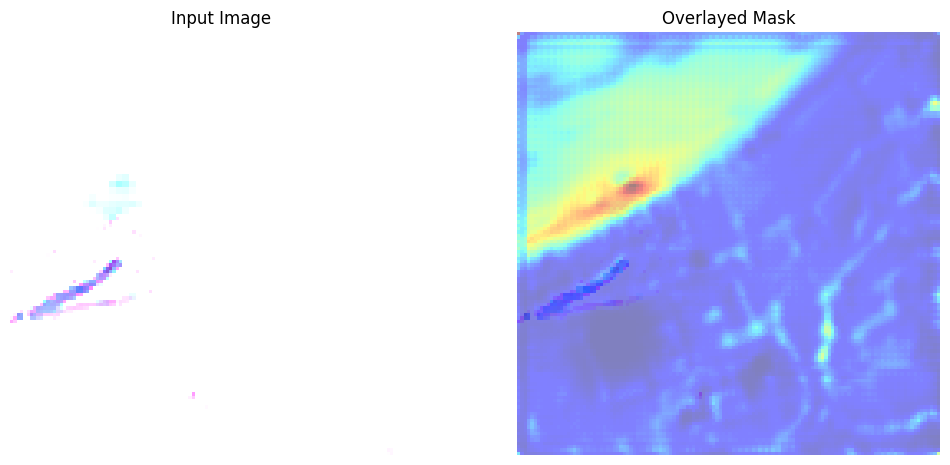

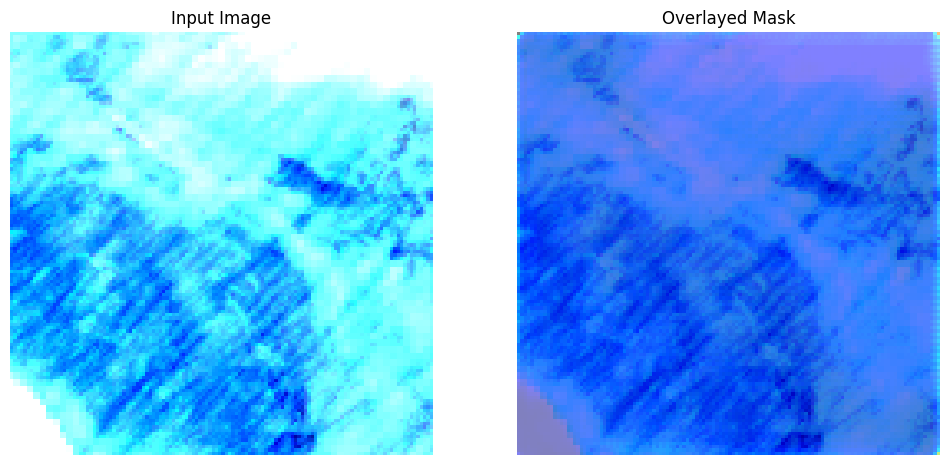

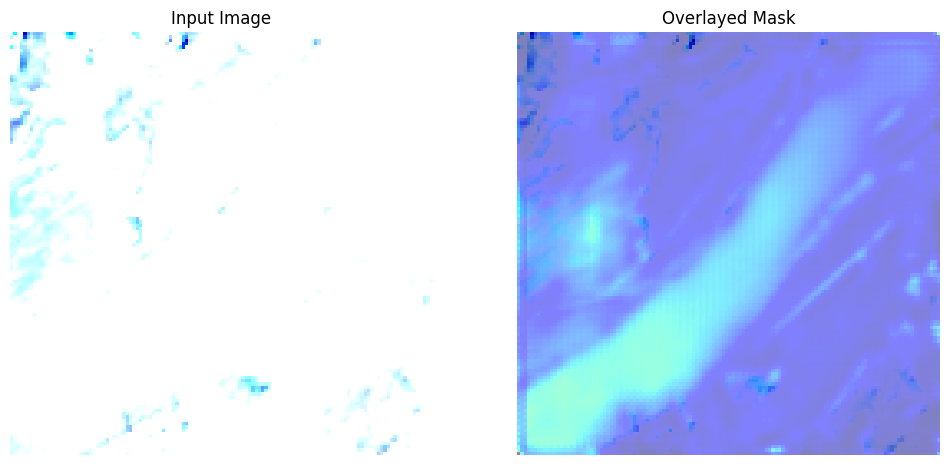

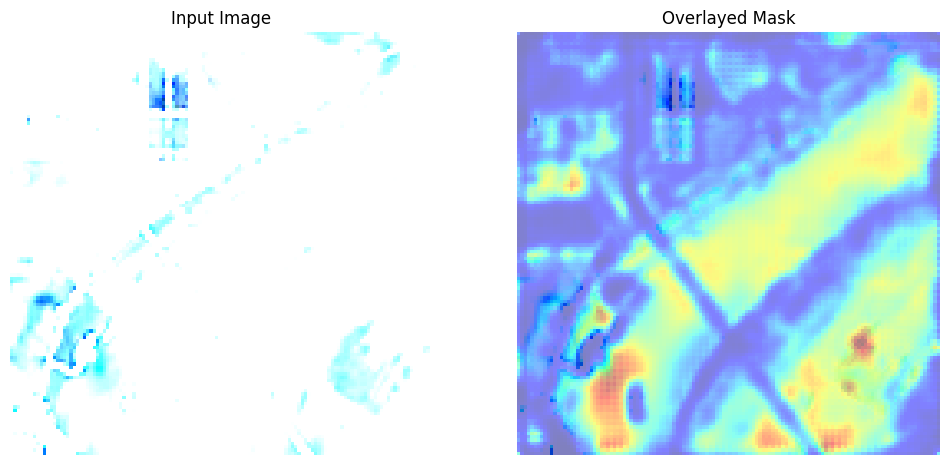

In [12]:
 def overlay_predictions(model, generator, alpha=0.5):
     images, masks = next(generator)
     predictions = model.predict(images)

     for i in range(len(images)):
         plt.figure(figsize=(12, 6))

         plt.subplot(1, 2, 1)
         plt.title("Input Image")
         plt.imshow(images[i])
         plt.axis('off')

         plt.subplot(1, 2, 2)
         plt.title("Overlayed Mask")
         plt.imshow(images[i])
         plt.imshow(predictions[i].squeeze(), cmap='jet', alpha=alpha)
         plt.axis('off')

         plt.show()
 overlay_predictions(model, val_generator)